In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
import datetime

#from library.sb_utils import save_file

In [2]:
# load the feature matrix to check whether it was properly saved.

feature_matrix = pd.read_csv('../data/processed/feature_matrix_skip2_TF_processed.csv')
feature_matrix.head().T

,0,1,2,3,4
Unnamed: 0,0,10000,20000,30000,40000
event_id,0,1,2,3,4
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5
skip_1,False,False,False,False,False
...,...,...,...,...,...
DIFF(tf.us_popularity_estimate) by session_id_skip_2_False,0.0,0.0,-0.071405,0.103248,-0.004938
DIFF(tf.us_popularity_estimate) by session_id_skip_2_True,0.0,0.0,0.0,0.0,0.0
DIFF(tf.valence) by session_id,NaN,0.184898,0.03671,0.275558,0.003501
DIFF(tf.valence) by session_id_skip_2_False,0.0,0.0,0.184898,0.03671,0.275558


In [3]:
feature_matrix.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('bool'), dtype('float64')],
      dtype=object)

In [4]:
feature_matrix.columns[feature_matrix.dtypes=='O']

Index(['session_id', 'session_id_skip_2_False', 'session_id_skip_2_True'], dtype='object')

In [5]:
# remove the rows containing NaN, as they are the first few skipped tracks in a session
feature_matrix.drop(columns=['skip_1', 'skip_3','not_skipped',
       'session_id_skip_2_False','session_id_skip_2_True','Unnamed: 0','event_id'],inplace=True)
#feature_matrix.dropna(inplace=True)

In [6]:
# the function of integrating the skipping labels into one column
def skip_label(df):
    skip = (df['not_skipped']==False).astype(int)*4 # no skip: 0, ultra-late skip: 4
    # It has to go under this order. If skip_1 = True, then skip_2 and _3 will be True too.
    skip[df['skip_3']==True] = 3 # late skip
    skip[df['skip_2']==True] = 2 # mid skip
    skip[df['skip_1']==True] = 1 # early skip
    return skip

# feature_matrix['skip_label'] = skip_label(feature_matrix)

In [7]:
feature_matrix.shape

(167880, 733)

In [8]:
feature_matrix.columns[0:50]

Index(['session_id', 'session_position', 'skip_2', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium', 'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection', 'euc_dist_all', 'cos_dist_all',
       'man_dist_all', 'CUM_MAX(context_switch) by session_id',
       'CUM_MAX(context_switch) by s

# Split the beginning/end of each sequence, random forest classifier, skip_2

This model will predict all the early and late skipping behavior.

In [ ]:
data_train_append = []
data_test_append = []
train_perc = 0.8
s_list = feature_matrix['session_id'].unique()

for s_id in s_list:
    temp = []
    temp = feature_matrix.loc[feature_matrix['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:round(len(temp)*train_perc),:])
    data_test_append.append(temp.iloc[round(len(temp)*train_perc):,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)

X_train = data_train.drop(columns=['skip_2', 'session_id'])
X_test = data_test.drop(columns=['skip_2', 'session_id'])
y_train = data_train['skip_2']
y_test = data_test['skip_2']

In [11]:
RF_MulClass = RandomForestClassifier(random_state=23, n_jobs = -1)
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train2 = imp_median.fit_transform(X_train)
X_test2 = imp_median.fit_transform(X_test)

RF_MulClass.fit(X_train2, y_train)
score_MulClass_train = RF_MulClass.score(X_train2,y_train)
score_MulClass_test = RF_MulClass.score(X_test2,y_test)
print('score_train',score_MulClass_train)
print('score_test',score_MulClass_test)

score_train 0.9994941003169313
score_test 0.7598159325882986


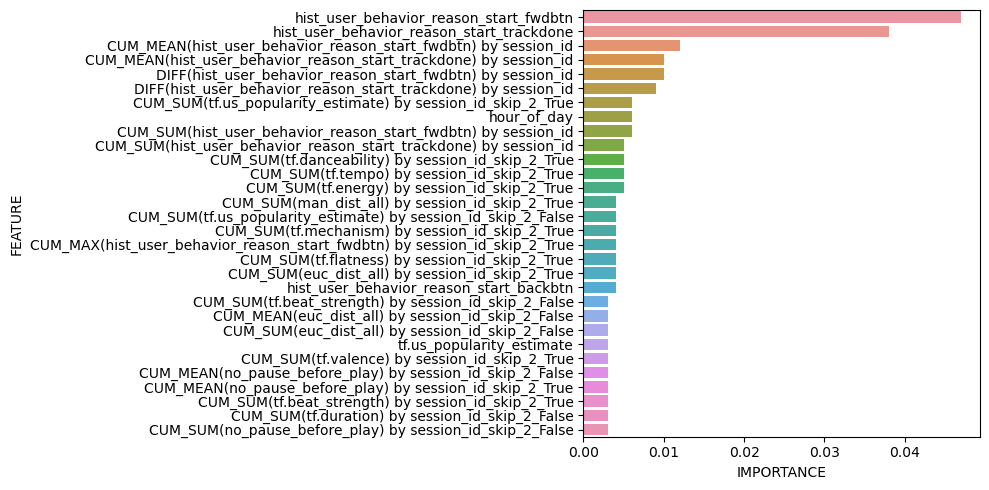

In [12]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_MulClass.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

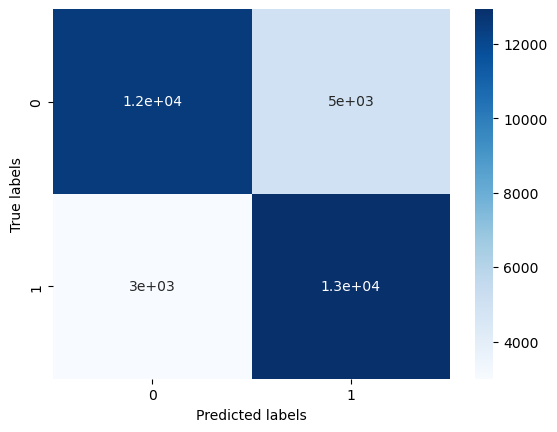

In [13]:
y_test_pred = RF_MulClass.predict(X_test2)
pl = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
p=sns.heatmap(pl, annot=True,cmap ='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

       False       0.81      0.71      0.76     17533
        True       0.72      0.81      0.76     15933

    accuracy                           0.76     33466
   macro avg       0.76      0.76      0.76     33466
weighted avg       0.77      0.76      0.76     33466



**Results of Model 3:** The model performs relatively well for no skip (0) and early skip (1), which is likely because they have more cases. But in general the model performance is not so good, compared to binary classification.

# Simple model 4: split the beginning/end of each sequence, random forest classifier with hyperparameter tuning, muticlasses
Not sure whether it can still be called as a simple model, but the hyperparameter tunning will be implemented here.

In [24]:
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, roc_auc_score

param_grid = {'n_estimators':np.arange(20,200,20), 
             'max_depth':[np.arange(10,100,10),None], 
             'class_weight': ['balanced', None]}
RF_MulClass_pt = RandomForestClassifier(random_state=23, n_jobs = -1)
rf_cv= GridSearchCV(RF_MulClass_pt,
                    param_grid,
                    cv=5, 
                    n_jobs = 6)
rf_cv.fit(X_train2,y_train)


pd.DataFrame(rf_cv.cv_results_).to_csv('../models/simpleModel/RF_GridSearchCV_noSkip_skip1_TF_processed.csv')
# from joblib import dump, load
# dump(rf_cv, '../models/simpleModel/RF_GridSearchCV_20221117.joblib') 

/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 68

In [25]:
pd.DataFrame(rf_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.290609,0.015745,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",20,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
1,2.072843,0.197340,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",40,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
2,1.915760,0.250434,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",60,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
3,1.994948,0.123349,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",80,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
4,2.137904,0.136769,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",100,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
5,1.972336,0.111442,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",120,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
6,2.034794,0.118573,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",140,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
7,2.106671,0.134895,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",160,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
8,2.092600,0.124978,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",180,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,33
9,65.569889,1.589027,0.348950,0.094062,balanced,None,20,"{'class_weight': 'balanced', 'max_depth': None...",0.614998,0.606889,0.614217,0.609493,0.615133,0.612146,0.003347,18


In [26]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.6366821772019311
Best Parameters: {'class_weight': None, 'max_depth': None, 'n_estimators': 180}


In [27]:
pd.DataFrame(rf_cv.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'param_max_depth', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [95]:
pd.DataFrame(rf_cv.cv_results_).sort_values('mean_test_f1_weighted')[['params','mean_test_f1_weighted','mean_test_accuracy','mean_test_balanced_accuracy']].head()

,params,mean_test_f1_weighted,mean_test_accuracy,mean_test_balanced_accuracy
45,"{'class_weight': 'balanced', 'max_depth': 60, ...",0.566791,0.598457,0.362806
72,"{'class_weight': 'balanced', 'max_depth': 90, ...",0.566860,0.598569,0.362893
63,"{'class_weight': 'balanced', 'max_depth': 80, ...",0.566860,0.598569,0.362893
54,"{'class_weight': 'balanced', 'max_depth': 70, ...",0.566860,0.598569,0.362893
36,"{'class_weight': 'balanced', 'max_depth': 50, ...",0.567050,0.598874,0.363244


**Results of Model 4:** Without feature engineering, the best parameters of the random forest model are {'class_weight': None, 'max_depth': 10, 'n_estimators': 50}, and the best accuracy was 64.4%, which is only 2% better.

# Split each sequence: multi-class (SVM)

In [31]:
# clf = make_pipeline(StandardScaler(), SVC(verbose = True, random_state=23))
# clf.fit(X_train, y_train)

[LibSVM]..............................................................................................................................*..............................................................................................................................*.*
optimization finished, #iter = 252227
obj = -36073.929342, rho = 0.292277
nSV = 47263, nBSV = 30604
.................................................*................................*
optimization finished, #iter = 81440
obj = -23087.018105, rho = -0.397195
nSV = 28683, nBSV = 21009
.................................................................*...........................................*.*
optimization finished, #iter = 108221
obj = -29105.703096, rho = -0.295036
nSV = 35559, nBSV = 26185
......................................................................................*.........................................................................................*.*
optimization finished, #iter = 176460
obj = -22031.591988

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=23, verbose=True))])

In [32]:
# score_clf_train = clf.score(X_train,y_train)
# score_clf_test = clf.score(X_test,y_test)
# print('score_train',score_clf_train)
# print('score_test',score_clf_test)

score_train 0.6678768580653801
score_test 0.6515568039203968


In [33]:
# from joblib import dump, load
# dump(clf, '../models/simpleModel/SVC_simple.joblib') 

['../models/simpleModel/SVC_simple.joblib']